# Asymptotic n-Particle Entanglement in a Luttinger Liquid after a Quantum Quench

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as π

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from collections import defaultdict
from scipy.special import binom
from scipy.interpolate import interp1d

import pickle

import include.colors as colortools
grey = '#9fa2b250'
with plt.style.context('./include/sans.mplstyle'):
    fig_size = plt.rcParams['figure.figsize']

### Setup some styling for the Jupyter notebook

In [2]:
from IPython.core.display import HTML
style = open('./include/custom.css', 'r').read()
HTML(f'<style>{style}</style>')

### Load useful quench functions from a script

In [3]:
import quenchutils as quench

## Load ED data from disk 

In the ED code, times are measured in units of inverse hopping, i.e. we measure $\overline{t} = t / (1/J) = t J$.  It may be useful to convert to the dimensionless time used for the Luttinger liquid which is measured in units of $a_0/v$, i.e. $v t / a_0$ where $a_0$ is the lattice spacing.  This is accomplished using the fact that from the Bethe Ansatz of the $J-V$ model we know:


\begin{equation}
\frac{v}{J a_0} = {\pi}\frac{\sqrt{1-(V/2J)^2}}{\cos^{-1}(V/2J)} 
\end{equation}

thus:

\begin{align*}
\frac{v t}{a_0} &= \frac{v}{J a_0}\, t J  \newline
& = (J t) \, {\pi} \frac{\sqrt{1-(V/2)^2}}{\cos^{-1}(V/2)}
\end{align*}

We can thus multiply our ED timescale by ${\pi} \frac{\sqrt{1-(V/2)^2}}{\cos^{-1}(V/2)}$.

In [4]:
EDp_n = {}
EDs_n = {}

Vi = 0.0
Vf = [-0.5,-0.25,-0.15,0.15,0.25,0.765]
Vp = [-0.15,0.15,-0.25,0.25,-0.5,0.765]
Δt = 0.1
ti = 0.0
tf = 100.0

N = np.array([4,5,6,7,8,9,10,11,12,13])
#n = [[1, int(cN/2)] for cN in N]
n = [np.array([cn for cn in range(1,int(cN/2)+1)]) for cN in N]
colors = colortools.get_linear_colors('Spectral',len(N),reverse=False)

for cVf in Vf:
    for i,cN in enumerate(N):
        for cn in n[i]:
            for bc in ['PBC']:
                data_dir = '../data/quench/ED/{:s}/'.format(bc)
                try:
                    p_data = np.loadtxt(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir))
                    EDp_n[quench.lookup(cN,Vi,cVf,Δt,cn,bc=bc)] = p_data
                except:
                    print("Can't load: {:s}".format(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir)))
            
                if cn == 1:
                    try:                   
                        s_data = np.loadtxt(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir,fmt='spatEE'))
                        EDs_n[quench.lookup(cN,Vi,cVf,Δt,cn,bc=bc)] = s_data
                    except:
                        print("Can't load: {:s}".format(quench.get_ED_fname(cN,Vi,cVf,Δt,ti,tf,cn,data_dir,fmt='spatEE')))

Can't load: ../data/quench/ED/PBC/partEE_20_10_+0.000_-0.500_0.1000_00.000_100.000_4.dat
Can't load: ../data/quench/ED/PBC/partEE_22_11_+0.000_-0.500_0.1000_00.000_100.000_4.dat
Can't load: ../data/quench/ED/PBC/partEE_26_13_+0.000_-0.500_0.1000_00.000_100.000_4.dat
Can't load: ../data/quench/ED/PBC/partEE_26_13_+0.000_-0.500_0.1000_00.000_100.000_5.dat
Can't load: ../data/quench/ED/PBC/partEE_26_13_+0.000_-0.500_0.1000_00.000_100.000_6.dat
Can't load: ../data/quench/ED/PBC/partEE_20_10_+0.000_-0.250_0.1000_00.000_100.000_4.dat
Can't load: ../data/quench/ED/PBC/partEE_22_11_+0.000_-0.250_0.1000_00.000_100.000_4.dat
Can't load: ../data/quench/ED/PBC/partEE_26_13_+0.000_-0.250_0.1000_00.000_100.000_4.dat
Can't load: ../data/quench/ED/PBC/partEE_26_13_+0.000_-0.250_0.1000_00.000_100.000_5.dat
Can't load: ../data/quench/ED/PBC/partEE_26_13_+0.000_-0.250_0.1000_00.000_100.000_6.dat
Can't load: ../data/quench/ED/PBC/partEE_20_10_+0.000_-0.150_0.1000_00.000_100.000_4.dat
Can't load: ../data/q

<div class="alert alert-warning">
    <h3> Note on data files</h3>
    We only compute all $n$-particle reduced density matrices (up to $\lfloor N/2 \rfloor$) for certain system sizes, i.e. $N=12$. $N=13,n=6$ was deemed to be too computationally intensive.  All wavefunction files are stored, but only final combined time evolution is stored in the repository in ../data.
</div>

## Plot the $n = \lfloor N/2 \rfloor$ entanglement per particle

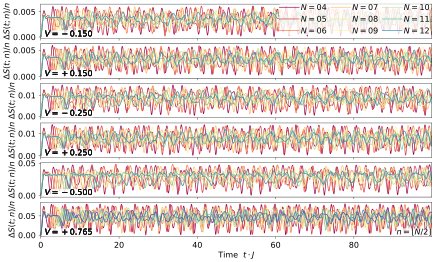

In [5]:
with plt.style.context('./include/sans.mplstyle'):

    fig, axes = plt.subplots(len(Vf),1,sharex=True, sharey=False, squeeze=True, figsize=(2*fig_size[0],2*fig_size[1]))
    fig.subplots_adjust(hspace=0.15)

    for iV,cVf in enumerate(Vp):
        for i,cN in enumerate(N):
            cn = int(cN/2)
            norm = 0.5*(1.0/cn + 1.0/(cN-cn))
            key = quench.lookup(cN,Vi,cVf,Δt,cn)
            if key in EDp_n:
                label = r'${:s}$'.format(key.split(',')[0])
                #scale = quench.tscalefactor(cVf)
                scale = 1
                x = np.linspace(EDp_n[key][0,0]*scale,EDp_n[key][-1,0]*scale,10000)
                y = interp1d(EDp_n[key][:,0]*scale, EDp_n[key][:,1]*norm, kind='cubic')
                axes[iV].plot(x,y(x),marker='None', color=colors[i],linewidth=0.7, mew=0, label=label, ms=3)

                axes[iV].set_ylabel('$\Delta S(t;n)/n$')
                axes[iV].text(0.01,0.06,'$V = {:+5.3f}$'.format(cVf),transform=axes[iV].transAxes,
                             bbox=dict(facecolor='white', edgecolor='None', alpha=0.15, pad=0.0),fontsize=8)

    axes[0].legend(frameon=True, loc=(0.61,0.1),ncol=3, handletextpad=0.2, columnspacing=0.5, edgecolor='None',borderpad=0.0)
    
    if scale == 1:
        xlabel = 'Time  $t \cdot J$'
    else:
        xlabel = 'Time  $v t / a_0$'
    axes[-1].set_xlabel(xlabel);
    axes[-1].text(0.91,0.065,r'$n = \lfloor N/2 \rfloor$'.format(cVf),transform=axes[iV].transAxes,
                             bbox=dict(facecolor='white', edgecolor='None', alpha=0.80, pad=0.0),fontsize=8)
    plt.xlim(0,99.9);

    plt.savefig('../figures/DeltaSn_vs_t_ED.pdf')
    plt.savefig('../figures/DeltaSn_vs_t_ED.svg')

## Plot the Spatial Entanglement per particle with the $t=0$ contribution removed

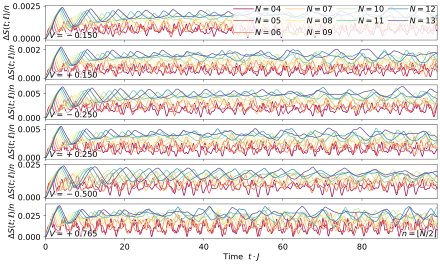

In [6]:
with plt.style.context('./include/sans.mplstyle'):
    fig, axes = plt.subplots(len(Vf),1,sharex=True, sharey=False, squeeze=True, figsize=(2*fig_size[0],2*fig_size[1]))
    #axes = np.array([axes])
    fig.subplots_adjust(hspace=0.15)

    for iV,cVf in enumerate(Vp):
        for i,cN in enumerate(N):
            key = quench.lookup(cN,Vi,cVf,Δt,1)
            label = r'${:s}$'.format(key.split(',')[0])
            
            #scale = quench.tscalefactor(cVf)
            scale = 1

            if key in EDs_n:
                x = np.linspace(EDs_n[key][0,0]*scale,EDs_n[key][-1,0]*scale,10000)
                y = interp1d(EDs_n[key][:,0]*scale,(EDs_n[key][:,1]-1.0*EDs_n[key][0,1])/(cN/2), kind='cubic')
                axes[iV].plot(x,y(x),marker='None', color=colors[i],  linewidth=0.7, label=label)

        axes[iV].set_ylabel('$\Delta S(t;\ell)/n$')
        axes[iV].text(0.01,0.06,'$V = {:+5.3f}$'.format(cVf),transform=axes[iV].transAxes,
                             bbox=dict(facecolor='white', edgecolor='None', alpha=0.65, pad=0.0),fontsize=8)

    axes[0].legend(frameon=True, loc=(0.48,0.095),ncol=4, handletextpad=0.2, columnspacing=0.5, edgecolor='None',borderpad=0.0)
    if scale == 1:
        xlabel = 'Time  $t \cdot J$'
    else:
        xlabel = 'Time  $v t / a_0$'
    axes[-1].set_xlabel(xlabel);
    axes[-1].text(0.91,0.065,r'$n = \lfloor N/2 \rfloor$'.format(cVf),transform=axes[iV].transAxes,
                             bbox=dict(facecolor='white', edgecolor='None', alpha=0.80, pad=0.0),fontsize=8)
    axes[-1].set_xlim(0,99);

    plt.savefig('../figures/DeltaSl_vs_t_ED.pdf')
    plt.savefig('../figures/DeltaSl_vs_t_ED.svg')

### Extract the asymptotic value

For the special case where $N$ is odd and $n = (N-1)/2$ we normalize via:

\begin{equation}
\frac{S_1(n)}{n} \to \frac{1}{2}\left[\frac{1}{n}S_1(n) + \frac{1}{N-n}S_1(N-n)\right] = S_1\left(n=\frac{N-1}{2}\right) \left(\frac{1}{N-1} + \frac{1}{N+1}\right)
\end{equation}

In [7]:
A1_asymp, ΔA1_asymp = {},{}
S1_asymp, ΔS1_asymp = {}, {}

for iV,cVf in enumerate(Vf):
    for i,cN in enumerate(N):
        for cn in n[i]: 
            for bc in ['PBC']:
                key = quench.lookup(cN,Vi,cVf,Δt,cn,bc=bc)

                # particle entanglement entropy
                if key in EDp_n:
                     
                    # this is the recurrence time predicted by LL theory where we start our average or half filling
                    idx = np.where(np.abs(EDp_n[key][:,0]*quench.tscalefactor(cVf)-cN)<Δt*quench.tscalefactor(cVf))[0][0]

                    if cn == int(cN/2):
                        norm = 0.5*(1.0/cn + 1.0/(cN-cn))
                    else:
                        norm = 1.0/cn
                        
                    cdata = EDp_n[key][idx:,1]*norm
                    A1_asymp[key] = np.average(cdata)
                    nb,Δ,ΔA1_asymp[key] = quench.binning_error(cdata)
                    
                    # check that the error isn't too large
                    if ΔA1_asymp[key]/A1_asymp[key] > 0.035:
                        print(f'Error {ΔA1_asymp[key]/A1_asymp[key]:.3f} is larger than 3.5% for {key}')
                
                # spatial entanglement entropy
                if cn == 1 and key in EDs_n:
                    idx = np.where(np.abs(EDs_n[key][:,0]*quench.tscalefactor(cVf)-cN)<Δt*quench.tscalefactor(cVf))[0][0]

                    norm = 2/cN
                    cdata = (EDs_n[key][idx:,1]-EDs_n[key][0,1])*norm
                    S1_asymp[key] = np.average(cdata)
                    nb,Δ,ΔS1_asymp[key] = quench.binning_error(cdata)
                    
                    # check that the error isn't too large
                    if ΔS1_asymp[key]/S1_asymp[key] > 0.035:
                        print(f'Error {ΔS1_asymp[key]/S1_asymp[key]:.3f} is larger than 3.5% for {key}')

Error 0.038 is larger than 3.5% for N=06, Vi=+0.000, Vf=+0.765, Δt=0.1000, n=1 PBC


## Paper Figure 2: time dependence of spatial and particle entanglement (per particle)
---

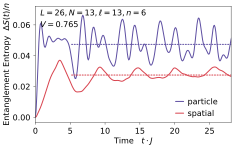

In [8]:
plt.style.reload_library()
with plt.style.context('./include/sans.mplstyle'):

    fig, axes = plt.subplots(1,1,sharex=True, sharey=False, squeeze=True)
    cVf = 0.765
    cN = 13

    # ==========================================================
    # particle entanglement
    # ==========================================================        
    cn = int(cN/2)
    key = quench.lookup(cN,Vi,cVf,Δt,cn)
    norm = 0.5*(1.0/cn + 1.0/(cN-cn))

    if key in EDp_n:
        
        ct = EDp_n[key][:,0]
        cS = EDp_n[key][:,1]*norm
        
        idx = np.where(np.abs(ct*quench.tscalefactor(cVf)-cN) < Δt*quench.tscalefactor(cVf))[0][0]
        
        axes.plot(ct,cS,marker='None', color=colors[-1], label='particle')
        axes.plot(ct[idx:],np.ones_like(ct[idx:])*A1_asymp[key], color=colors[-1], linestyle=':')

    # ==========================================================
    # spatial entanglement
    # ==========================================================
    
    key = quench.lookup(cN,Vi,cVf,Δt,1)
    norm = 2.0/cN

    if key in EDs_n:
        ct = EDs_n[key][:,0]
        cS = (EDs_n[key][:,1]-EDs_n[key][0,1])*norm
        idx = np.where(np.abs(ct*quench.tscalefactor(cVf)-cN) < Δt*quench.tscalefactor(cVf))[0][0]
        
        axes.plot(ct,cS,marker='None', color=colors[1], label='spatial')
        axes.plot(ct[idx:],np.ones_like(ct[idx:])*S1_asymp[key], color=colors[1], linestyle=':')

        axes.set_ylabel('Entanglement Entropy  $\Delta S(t) / n$')
        axes.set_xlabel('Time   $t\cdot J$')
    
        axes.text(0.025,0.82,f'$V = {cVf:5.3f}$',transform=axes.transAxes, fontsize=8, fontweight=300)
        axes.text(0.025,0.92,f'$L = {2*cN:d}, N = {cN:d}, \ell = {cN:d}, n = {cn:d}$',transform=axes.transAxes, fontsize=8, fontweight=300)
        axes.legend(frameon=False, loc=(0.7,0.015), handletextpad=0.5, handlelength=1.0)

        axes.set_xlim(0,28.1);

        plt.savefig('../figures/DeltaS_vs_t_ED.pdf')
        plt.savefig('../figures/DeltaS_vs_t_ED.svg')

## Combine Asymptotic Values and perform a FSS fit

Here we consider two fitting forms:

\begin{equation}
\frac{1}{n} \Delta S(t\to\infty) = \mathfrak{s} + \mathcal{C} \frac{\ln N}{N}
\label{eq:fit1}\tag{1}
\end{equation}

\begin{equation}
\frac{1}{n} \Delta S(t\to\infty) = \mathfrak{s} + \mathcal{C} \frac{\ln N}{N} + \frac{\mathcal{A}}{N}
\label{eq:fit2}\tag{2}
\end{equation}

<div class="alert alert-warning">
In the second case, we do not have enough data points to extract $\mathcal{A}$ without considerable uncertainity, however we have confirmed that the extracted intercept still falls within the error of the extra parameter fit. We thus choose fitting form \eqref{eq:fit1}.
 </div>

In [9]:
from lmfit import minimize, Parameters

def get_fit(x,y,Δy):
    fit_params = Parameters()
    fit_params.add('asymp', value=0.05, min=0.0, max=1.0)
    fit_params.add('scale', value=-0.1, min=-1.5, max=1.5)

    def fss_residual(params, x_, y_, Δy_):
        asymp = params['asymp'].value
        scale = params['scale'].value
        return (asymp + scale*x_ - y_)/Δy_
    
    fit = minimize(fss_residual, fit_params, args=(x,y,Δy))    
    return np.poly1d([fit.params['scale'],fit.params['asymp']]), fit.params['asymp'].stderr

def get_fit1(x,y,Δy):
    fit_params = Parameters()
    fit_params.add('asymp', value=0.05, min=0.0, max=1.0)
    fit_params.add('scale', value=-0.1, min=-1.5, max=0.0)
    fit_params.add('a', value=0.0)

    def fss_residual(params, x_, y_, Δy_):
        asymp = params['asymp'].value
        scale = params['scale'].value
        a = params['a'].value

        return (asymp + scale*x_*np.log(x_) + a*x_ - y_)/Δy_
    
    fit = minimize(fss_residual, fit_params, args=(x,y,Δy))   
    print(fit.params['a'].value)

    return lambda x_: fit.params['asymp'].value + fit.params['scale'].value*x_*np.log(x_) + fit.params['a'].value*x_, fit.params['asymp'].stderr

In [41]:
fS1_fit,fAn_fit = {},{}
ΔfS1_fss,ΔfAn_fss = {},{}

start_ = {'PBC':4, 'OBC':0}
for iV,cVf in enumerate(Vf): 
    for bc in ['PBC']:
        Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)
    
        An_data = np.array([[cN,A1_asymp[quench.lookup(cN,Vi,cVf,Δt,n[i][-1],bc=bc)]]\
                            for i,cN in enumerate(N) if quench.lookup(cN,Vi,cVf,Δt,n[i][-1],bc=bc) in A1_asymp])
        S1_data = np.array([[cN,S1_asymp[quench.lookup(cN,Vi,cVf,Δt,1,bc=bc)]]\
                            for cN in N if quench.lookup(cN,Vi,cVf,Δt,1,bc=bc) in S1_asymp])
        
        ΔAn_data = np.array([[cN,ΔA1_asymp[quench.lookup(cN,Vi,cVf,Δt,n[i][-1],bc=bc)]]\
                             for i,cN in enumerate(N) if quench.lookup(cN,Vi,cVf,Δt,n[i][-1],bc=bc) in ΔA1_asymp])
        ΔS1_data = np.array([[cN,ΔS1_asymp[quench.lookup(cN,Vi,cVf,Δt,1,bc=bc)]]\
                             for cN in N if quench.lookup(cN,Vi,cVf,Δt,1,bc=bc) in ΔS1_asymp])
            
        if S1_data.size > 0:
            cstart = start_[bc]+0
            cN = S1_data[cstart:,0]
            x = np.log(cN)/cN
            fS1_fit[Vkey],ΔfS1_fss[Vkey] = get_fit(x,S1_data[cstart:,1],ΔS1_data[cstart:,1])
    
        if An_data.size > 0:
            if bc == 'PBC':
                cstart = start_[bc]
                cN = An_data[cstart:,0]
                x = np.log(cN)/cN
                fAn_fit[Vkey],ΔfAn_fss[Vkey] = get_fit(x,An_data[cstart:,1],ΔAn_data[cstart:,1])


## Investigate the $n$ dependence of the n-particle entanglement

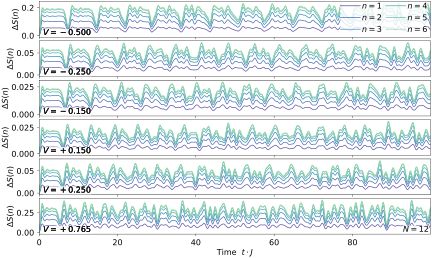

In [45]:
# Get some colors for plotting interaction dependence of particle entanglement
ncolors = colortools.get_linear_colors('Spectral',2*len(N),reverse=True)

with plt.style.context('./include/sans.mplstyle'):
    fig, axes = plt.subplots(len(Vf),1,sharex=True, sharey=False, squeeze=True, figsize=(2*fig_size[0],2*fig_size[1]))
    fig.subplots_adjust(hspace=0.1)

    cN = 12
    iN = np.where(N==cN)[0][0]
    for iV,cVf in enumerate(Vf):
        for i,cn in enumerate(n[iN]):
            key = quench.lookup(cN,Vi,cVf,Δt,cn)
            if key in EDp_n:
                label = f'$n = {cn}$'
                x = np.linspace(EDp_n[key][0,0],EDp_n[key][-1,0],10000)
                y = interp1d(EDp_n[key][:,0], EDp_n[key][:,1], kind='cubic')
                axes[iV].plot(x,y(x),marker='None', color=ncolors[i], 
                              linewidth=0.7, mew=0, label=label, ms=3)

                axes[iV].set_ylabel('$\Delta S(n)$')
                axes[iV].text(0.01,0.06,'$V = {:+5.3f}$'.format(cVf),transform=axes[iV].transAxes,
                             bbox=dict(facecolor='white', edgecolor='None', alpha=0.25, pad=0.0),fontsize=8)

    axes[0].legend(frameon=True, loc=(0.77,0.1),ncol=2, handletextpad=0.2, columnspacing=0.5, edgecolor='None',borderpad=0.0)
    axes[-1].set_xlabel('Time  $t \cdot J$');
    axes[-1].text(0.93,0.065,f'$N = {cN}$'.format(cVf),transform=axes[iV].transAxes,
                             bbox=dict(facecolor='white', edgecolor='None', alpha=0.80, pad=0.0),fontsize=8)
    plt.xlim(0,99.9);

    plt.savefig(f'../figures/n_dependence_N_{cN}_DeltaSn_vs_t_ED.pdf')
    plt.savefig(f'../figures/n_dependence_N_{cN}_DeltaSn_vs_t_ED.svg')

## Paper Supplement Figure: $n$-dependence
---

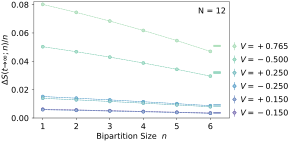

In [47]:
plt.style.reload_library()
with plt.style.context('./include/sans.mplstyle'):

    fig, axes = plt.subplots(1,1,sharex=True, sharey=False, squeeze=True)
    cN = 12
    iN = np.where(N==cN)[0][0]

    Vp = [-0.15,0.15,-0.25,0.25,-0.5,0.765]
    for iV,cVf in enumerate(Vp):
    
        props = {'mec':ncolors[iV],'mew':0.5, 'ecolor':ncolors[iV], 'elinewidth':0.5,'ms':3,
                 'mfc':colortools.get_alpha_hex(ncolors[iV],0.5), 'color':ncolors[iV], 'ls':'--', 'lw':0.5}
        Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)
        
        An_asymp, ΔAn_asymp = [],[]
        for i,cn in enumerate(n[iN]):
            key = quench.lookup(cN,Vi,cVf,Δt,cn)
            An_asymp.append(A1_asymp[key])
            ΔAn_asymp.append(ΔA1_asymp[key])
    
        
        axes.errorbar(n[iN],An_asymp,yerr=ΔAn_asymp, marker='o',label=f'$V = {cVf:>+5.3f}$', **props)
        low = fAn_fit[Vkey](1E-16)-ΔfAn_fss[Vkey]
        high = fAn_fit[Vkey](1E-16)+ΔfAn_fss[Vkey]

        plt.fill_between([6.1,6.3],[low,low],[high,high],clip_on=False, zorder=-10, 
                                         color=ncolors[iV], alpha=0.6)

    axes.text(0.84,0.9,f'N = {cN:d}',transform=axes.transAxes, fontsize=8, fontweight=300)

    axes.set_xlabel('Bipartition Size  $n$')
    axes.set_ylabel(r'$\Delta S(t\to\infty;n)/n$')
    axes.set_ylim(0,0.082)
    
    # inside legend
#     axes.legend(ncol=2, frameon=False, loc=(0.0,0.175), fontsize=8, labelspacing=0.25, 
#                    handletextpad=0.5, handlelength=0.5,columnspacing=0.8)
    
    # outside legend
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles[::-1], labels[::-1],ncol=1, frameon=False, loc=(1.0,-0.02), fontsize=8, labelspacing=0.7, 
                   handletextpad=0.5, handlelength=0.5)

    plt.savefig(f'../figures/deltaSon_vs_n_N_{cN}.pdf')
    plt.savefig(f'../figures/deltaSon_vs_n_N_{cN}.svg')

## Paper Figure 3: 1/N Log N fit
---

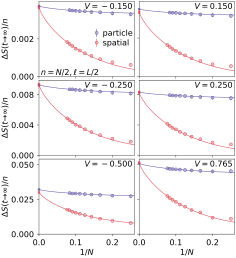

In [48]:
plt.style.reload_library()
with plt.style.context('./include/sans.mplstyle'):
    
    fig, axes = plt.subplots(3,2,sharex=False, sharey=False, squeeze=True, figsize=(fig_size[0],2*fig_size[1]))
    axes = axes.flatten()
    
    inv_N_fit = np.linspace(1E-16,0.5,1000)
    x = inv_N_fit*np.log(1/inv_N_fit)
    ls = ['-','--']
    marker = {'PBC':'o', 'OBC':'x'}
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # re-order interaction strengths
    Vp = [-0.15,0.15,-0.25,0.25,-0.5,0.765]
    for iV,cVf in enumerate(Vp):     

        for bc in ['PBC']:

            Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)
            
            # ==========================================================
            # particle entanglement
            # ========================================================== 
            
            # particle entanglement FSS fit
            axes[iV].plot(inv_N_fit,fAn_fit[Vkey](x), color=colors[-1], ls='-', lw=0.5)
            low = fAn_fit[Vkey](x[0])-ΔfAn_fss[Vkey]
            high = fAn_fit[Vkey](x[0])+ΔfAn_fss[Vkey]
            axes[iV].fill_between([-0.002,0.002],[low,low],[high,high],clip_on=False, zorder=10, 
                                         color=colors[-1], alpha=0.6)

            # particle entanglement ED data
            props = {'mec':colors[-1],'mew':0.5, 'ecolor':colors[-1], 'elinewidth':0.5, 'ls':'None','ms':3,
                     'mfc':colortools.get_alpha_hex(colors[-1],0.5)+'80'}

            for i,cN in enumerate(N):
                cn = n[i][-1]

                key = quench.lookup(cN,Vi,cVf,Δt,cn)
                if key in A1_asymp:
                    if i==0:
                        label = 'particle'
                    else:
                        label=''
                    
                    axes[iV].errorbar(1/cN,A1_asymp[key],yerr=ΔA1_asymp[key], marker='o',
                                      label=label, **props)

            # ==========================================================
            # spatial entanglement
            # ========================================================== 
            
            # spatial entanglement FSS fit
            axes[iV].plot(inv_N_fit,fS1_fit[Vkey](x), color=colors[1], ls='-',lw=0.5)
            low = fS1_fit[Vkey](x[0])-ΔfS1_fss[Vkey]
            high = fS1_fit[Vkey](x[0])+ΔfS1_fss[Vkey]
            axes[iV].fill_between([-0.002,0.002],[low,low],[high,high],clip_on=False, zorder=10, 
                                 color=colors[1], alpha=0.6)

            # spatial entanglement ED data
            props = {'mec':colors[1],'mew':0.5, 'ecolor':colors[1], 'elinewidth':0.5, 'ls':'None','ms':3,
                      'mfc':colortools.get_alpha_hex(colors[1],0.5)+'80'}
            for i,cN in enumerate(N):
                key = quench.lookup(cN,Vi,cVf,Δt,1,bc=bc)
                if key in S1_asymp:
                    if i==0:
                        label = 'spatial'
                    else:
                        label=''

                    axes[iV].errorbar(1.0/cN,S1_asymp[key],yerr=ΔS1_asymp[key],
                                          marker=marker[bc],label=label, **props)


        axes[iV].text(0.98,0.9,f'$V = {cVf:5.3f}$',transform=axes[iV].transAxes, ha='right', fontsize=8)
        axes[iV].set_xlim(0,0.26)
        
        # Deal with Axes 
        if iV % 2:
            axes[iV].axes.yaxis.set_ticklabels([])
        else:
            axes[iV].set_ylabel(r'$\Delta S(t\to\infty)/n$')

        if iV <4:
            axes[iV].axes.xaxis.set_ticklabels([])
            
    # add information of partition size
    axes[0].text(0.02,0.02,'$n = N/2, \ell = L/2$',transform=axes[0].transAxes, ha='left', fontsize=8)

    # manually configure axis
    axes[-2].set_xlabel('$1/N$')
    axes[-1].set_xlabel('$1/N$')
    
    ticks = [0.0,0.004,0.008]
    axes[2].set_yticks(ticks)
    axes[3].set_yticks(ticks)
    
    ticks = [0.0,0.025,0.050]
    axes[4].set_yticks(ticks)
    axes[5].set_yticks(ticks)

    axes[0].set_ylim(0,0.00399)
    axes[1].set_ylim(0,0.0039)
    axes[2].set_ylim(0,0.0099)
    axes[3].set_ylim(0,0.0099)
    axes[4].set_ylim(0,0.054)
    axes[5].set_ylim(0,0.054)
    
    axes[0].legend(ncol=1, frameon=False, loc=(0.55,0.35), fontsize=8, labelspacing=0.25, 
                   handletextpad=0.5, handlelength=0.5)

    plt.savefig('../figures/asymptotic_entropy_vs_invN_LL_prediction.pdf')
    plt.savefig('../figures/asymptotic_entropy_vs_invN_LL_prediction.svg')

## Compare the Extrapolated Values with the LL Boson Prediction

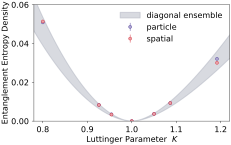

In [49]:
Sb_low,Sb_high = [],[]
Ss = []
ΔSs = []
Sn = []
ΔSn = []

Vp = [-0.5,-0.25,-0.15,0.0,0.15,0.25,0.765]
for iV,cVf in enumerate(Vp):
    if np.abs(cVf)<1E-6:
        Sb_low.append(0)
        Sb_high.append(0)
        Ss.append(0)
        Sn.append(0)
        ΔSs.append(0)
        ΔSn.append(0)
    else:   
        
        Sb_high.append(quench.Sb1(1.0/2.5,quench.γeq(quench.KV(cVf))))
        Sb_low.append(quench.Sb1(1.0/1.8,quench.γeq(quench.KV(cVf))))
    
        Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,'PBC')
        Ss.append(fS1_fit[Vkey](0.0))
        ΔSs.append(ΔfS1_fss[Vkey])
        Sn.append(fAn_fit[Vkey](0.0))
        ΔSn.append(ΔfAn_fss[Vkey])

with plt.style.context('./include/sans.mplstyle'):
    fig, axes = plt.subplots(1,1,sharex=True, sharey=False, squeeze=True)

 
    props = {'mec':colors[-1],'mew':0.5, 'ecolor':colors[-1], 'elinewidth':0.5, 'ls':'None','ms':3,
             'mfc':colortools.get_alpha_hex(colors[-1],0.5)}
    axes.errorbar(quench.KV(np.array(Vp)),Sn,yerr=ΔSn, marker='o',label='particle', **props)

    props = {'mec':colors[1],'mew':0.5, 'ecolor':colors[1], 'elinewidth':0.5, 'ls':'None','ms':3,
             'mfc':colortools.get_alpha_hex(colors[1],0.5)}
    axes.errorbar(quench.KV(np.array(Vp)),Ss,yerr=ΔSs, marker='o',label=r'spatial', **props)
    
    fit_K = np.linspace(0.75,1.25,100)
    high = quench.Sb1(0.55,quench.γeq(fit_K))
    low  = quench.Sb1(0.4,quench.γeq(fit_K))
    axes.fill_between(fit_K,low,high,clip_on=True, zorder=-10, 
                                             color=grey, alpha=0.4, label='diagonal ensemble')
    #axes.fill_between(quench.KV(np.array(Vp)),Sb_low,Sb_high,clip_on=False, zorder=-10, 
    #                                         color=green, alpha=0.4, label='Luttinger liquid')

    axes.set_xlim(0.78,1.22)
    axes.set_ylim(0,0.06)

    axes.legend()
    axes.set_ylabel('Entanglement Entropy Density')
    axes.set_xlabel('Luttinger Parameter  $K$');
    
    plt.savefig('../figures/extrapolated_EE.pdf')
    plt.savefig('../figures/extrapolated_EE.svg')

### Make a combined plot showing structure factor and entanglement entropy

#### Load relevent data from disk

The predictions for $\langle n_q \rangle$ have been generated in the [structure factor notebook](./g2_quantum_quench.ipynb).

In [50]:
with open('../figures/Sq_boson_fit.pickle', 'rb') as pfile:
    structure = pickle.load(pfile)

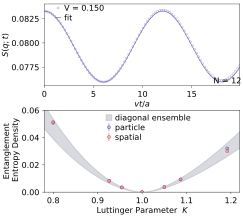

In [51]:
plt.style.reload_library()
with plt.style.context('./include/sans.mplstyle'):
    fig, axes = plt.subplots(2,1,sharex=False, sharey=False, squeeze=True, figsize=(fig_size[0],fig_size[0]))
    fig.subplots_adjust(hspace=0.3)
    cVf = 0.15
    cN = 12
    q_index = 0

    key = quench.lookup(cN,Vi,cVf,Δt,1)
    K = quench.KV(cVf)
    kF = structure['kF']
    
    qlabel = r'$S(q/k_{{\rm F}}={:.2f};t)$'.format(structure['q'][key][q_index]/kF)
    
    # S(q;t) for a single value of V
    props = {'mec':colors[-1],'mew':0.5, 'ls':'None','ms':2, 'mfc':'None'}
    flabel = r'fit: $1 + 2n_{\rm LL} + \sinh(2\beta)\cos(2\omega_q t)$'
    axes[0].plot(structure['x1'],structure['y1'], 'o', **props, label=f'V = {cVf:5.3f}', alpha=0.5)
    axes[0].plot(structure['x2'],structure['y2'],'-', color=colors[-1], linewidth=0.5, label=r'fit', zorder=-10)
    axes[0].set_xlabel(r'$vt/a$')
    axes[0].set_ylabel(r'$S(q;t)$')
    axes[0].text(0.865,0.03,f'N = {cN}',transform=axes[0].transAxes, fontsize=8, ha='left')
    axes[0].set_xlim(0,19.9)
    axes[0].legend(frameon=False, loc=(0.04,0.74), handletextpad=0.4, handlelength=0.7, ncol=1, 
                   labelspacing=0.25)
    
    # ------------------------------------------------------------------------------------
    # LL Prediction for EE
    # ------------------------------------------------------------------------------------
    
    props = {'mec':colors[-1],'mew':0.5, 'ecolor':colors[-1], 'elinewidth':0.5, 'ls':'None','ms':3,
             'mfc':colortools.get_alpha_hex(colors[-1],0.5)+'80'}
    axes[1].errorbar(quench.KV(np.array(Vp)),Sn,yerr=ΔSn, marker='o',label='particle', **props)

    props = {'mec':colors[1],'mew':0.5, 'ecolor':colors[1], 'elinewidth':0.5, 'ls':'None','ms':3,
             'mfc':colortools.get_alpha_hex(colors[1],0.5)+'80'}
    axes[1].errorbar(quench.KV(np.array(Vp)),Ss,yerr=ΔSs, marker='o',label=r'spatial', **props)
    
    grey = '#9fa2b2'
    green = '#66c2a6'
    
    
    fit_K = np.linspace(0.75,1.25,100)
    high = quench.Sb1(0.55,quench.γeq(fit_K))
    low  = quench.Sb1(0.4,quench.γeq(fit_K))
    axes[1].fill_between(fit_K,low,high,clip_on=True, zorder=-10, 
                                             color=grey, alpha=0.4, label='diagonal ensemble')
    #axes.fill_between(quench.KV(np.array(Vp)),Sb_low,Sb_high,clip_on=False, zorder=-10, 
    #                                         color=green, alpha=0.4, label='Luttinger liquid')

    axes[1].set_xlim(0.78,1.22)
    axes[1].set_ylim(0,0.06)

    axes[1].legend(loc=(0.3,0.58),handletextpad=0.4, handlelength=0.7,labelspacing=0.25)
    axes[1].set_ylabel('Entanglement\n Entropy Density')
    axes[1].set_xlabel('Luttinger Parameter  $K$');
    
    plt.savefig(f'../figures/SqnLL_N{cN}_EE.pdf')
    plt.savefig(f'../figures/SqnLL_N{cN}_EE.svg')

## Paper Figure 4: LL Predictions
---

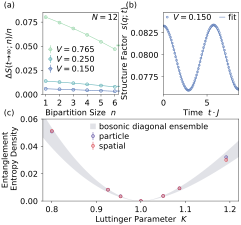

In [52]:
import matplotlib.gridspec as gridspec
plt.style.reload_library()
with plt.style.context('./include/sans.mplstyle'):
    fig = plt.figure(figsize=(fig_size[0],fig_size[0]))
    gs = gridspec.GridSpec(2, 2)
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[1,:])
    axes = [ax1,ax2,ax3]

    cN = 12
    iN = np.where(N==cN)[0][0]

    # ------------------------------------------------------------------------------------
    # n-dependence of obdm
    # ------------------------------------------------------------------------------------
    Vp = [-0.15,0.15,-0.25,0.25,-0.5,0.765]
    for iV,cVf in enumerate(Vp):
    
        props = {'mec':ncolors[iV],'mew':0.5, 'ecolor':ncolors[iV], 'elinewidth':0.5,'ms':3,
                 'mfc':colortools.get_alpha_hex(ncolors[iV],0.5)+'80', 'color':ncolors[iV], 'ls':'-', 'lw':0.5}
        Vkey = 'Vf={:+5.3f} {:s}'.format(cVf,bc)
        
        An_asymp, ΔAn_asymp = [],[]
        for i,cn in enumerate(n[iN]):
            key = quench.lookup(cN,Vi,cVf,Δt,cn)
            An_asymp.append(A1_asymp[key])
            ΔAn_asymp.append(ΔA1_asymp[key])
        
        if cVf >0 :
            axes[0].errorbar(n[iN],An_asymp,yerr=ΔAn_asymp, marker='o',label=f'$V = {cVf:5.3f}$', **props)
            low = fAn_fit[Vkey](x[0])-ΔfAn_fss[Vkey]
            high = fAn_fit[Vkey](x[0])+ΔfAn_fss[Vkey]

            axes[0].fill_between([6.15,6.35],[low,low],[high,high],clip_on=False, zorder=-10, 
                                         color=ncolors[iV], alpha=0.6)

    axes[0].text(0.65,0.91,f'$N = {cN:d}$',transform=axes[0].transAxes, fontsize=8, fontweight=300)

    axes[0].set_xlabel('Bipartition Size  $n$')
    axes[0].set_ylabel(r'$\Delta S(t\to\infty;n)/n$')
    axes[0].set_ylim(0,0.085)
    axes[0].set_xlim(0.8,6.25)
    
    #axes.legend(ncol=3, frameon=False, loc=(0.01,0.175), fontsize=8, labelspacing=0.25, 
     #              handletextpad=0.5, handlelength=0.5) 
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1],labels[::-1],ncol=1, frameon=False, loc=(0.03,0.22), fontsize=8, labelspacing=0.25, 
                   handletextpad=0.5, handlelength=0.5, columnspacing=0.8)
    
      
    ticks = [1,2,3,4,5,6]
    axes[0].set_xticks(ticks)
    
        
    # ------------------------------------------------------------------------------------
    # Time dependence of structure factor
    # ------------------------------------------------------------------------------------
    cVf = 0.15
    cN = 12
    q_index = 1

    key = quench.lookup(cN,Vi,cVf,Δt,1)
    K = quench.KV(cVf)
    kF = structure['kF']
    
    qlabel = r'$S(q/k_{{\rm F}}={:.2f};t)$'.format(structure['q'][key][q_index]/kF)
    
    # S(q;t) for a single value of V
    props = {'mec':ncolors[1],'mew':0.4, 'ls':'None','ms':2, 'mfc':colortools.get_alpha_hex(ncolors[1],0.5)+'80'}
    flabel = r'fit: $1 + 2n_{\rm LL} + \sinh(2\beta)\cos(2\omega_q t)$'
    
    axes[1].plot(structure['x1']/quench.tscalefactor(cVf),structure['y1'], 'o', **props, label=f'$V = {cVf:5.3f}$')
    axes[1].plot(structure['x2']/quench.tscalefactor(cVf),structure['y2'],'-', color=ncolors[1], linewidth=0.5, label=r'fit', zorder=-10)
    axes[1].set_xlabel(r'Time  $t\cdot J$')
    axes[1].set_ylabel(r'Structure Factor  $s(q;t)$')
    #axes[1].text(0.65,0.9,f'N = {cN}',transform=axes[1].transAxes, fontsize=8, ha='left')
    axes[1].set_xlim(0,8.65)
    axes[1].set_ylim(0.0755,0.0848)
  
    axes[1].legend(frameon=False, loc=(-0.03,0.85), handletextpad=0.4, handlelength=0.7, ncol=2, 
                   labelspacing=0.25, columnspacing=1)
    
    # ------------------------------------------------------------------------------------
    # LL Prediction for EE
    # ------------------------------------------------------------------------------------
    Vp = [-0.5,-0.25,-0.15,0.0,0.15,0.25,0.765]
    props = {'mec':colors[-1],'mew':0.5, 'ecolor':colors[-1], 'elinewidth':0.5, 'ls':'None','ms':3,
             'mfc':colortools.get_alpha_hex(colors[-1],0.5)+'80'}
    axes[2].errorbar(quench.KV(np.array(Vp)),Sn,yerr=ΔSn, marker='o',label='particle', **props)

    props = {'mec':colors[1],'mew':0.5, 'ecolor':colors[1], 'elinewidth':0.5, 'ls':'None','ms':3,
             'mfc':colortools.get_alpha_hex(colors[1],0.5)+'80'}
    axes[2].errorbar(quench.KV(np.array(Vp)),Ss,yerr=ΔSs, marker='o',label=r'spatial', **props)
    
    grey = '#9fa2b250'
    green = '#66c2a6'
    
    
    fit_K = np.linspace(0.75,1.25,100)
    high = quench.Sb1(0.55,quench.γeq(fit_K))
    low  = quench.Sb1(0.4,quench.γeq(fit_K))
    axes[2].fill_between(fit_K,low,high,clip_on=True, zorder=-10, 
                                             color=grey, label='bosonic diagonal ensemble',lw=0, edgecolor=grey)
    #axes.fill_between(quench.KV(np.array(Vp)),Sb_low,Sb_high,clip_on=False, zorder=-10, 
    #                                         color=green, alpha=0.4, label='Luttinger liquid')

    axes[2].set_xlim(0.78,1.22)
    axes[2].set_ylim(0,0.06)

    axes[2].legend(loc=(0.225,0.58),handletextpad=0.4, handlelength=0.7,labelspacing=0.25)
    axes[2].set_ylabel('Entanglement\n Entropy Density')
    axes[2].set_xlabel('Luttinger Parameter  $K$');    
    
    fig.subplots_adjust(wspace=0.6,hspace=0.3)
    
    # add sub-figure labels
    fig.text(-0.01,0.94,'(a)', fontsize=8, ha='left')
    fig.text(0.488,0.94,'(b)', fontsize=8, ha='left')
    fig.text(-0.01,0.5,'(c)', fontsize=8, ha='left')

    plt.savefig(f'../figures/nobdm_SqnLL_N{cN}_EE.pdf');
    plt.savefig(f'../figures/nobdm_SqnLL_N{cN}_EE.svg');
    